#### This notebook shows how to read the M4Raw dataset and apply some simple transformations to the data.
#### Refer to fastMRI

In [1]:
# Testing if integration works

In [2]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import os

In [14]:
data_folder = './raid/SZTU200H5/';
file_name = os.path.join(data_folder, '2022061003_FLAIR01.h5')
hf = h5py.File(file_name)

In [15]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))
# 头部平扫序列axT2

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXFLAIR', 'max': 115.29900007154666, 'patient_id': '88448eec274d9248d1a2487a8548ee41'}


   h5py文件是存放两类对象的容器，数据集(dataset)和组(group)，dataset类似数组类的数据集合，和numpy的数组差不多。group是像文件夹一样的容器，它好比python中的字典，有键(key)和值(value)。group中可以存放dataset或者其他的group。”键”就是组成员的名称，”值”就是组成员对象本身(组或者数据集)
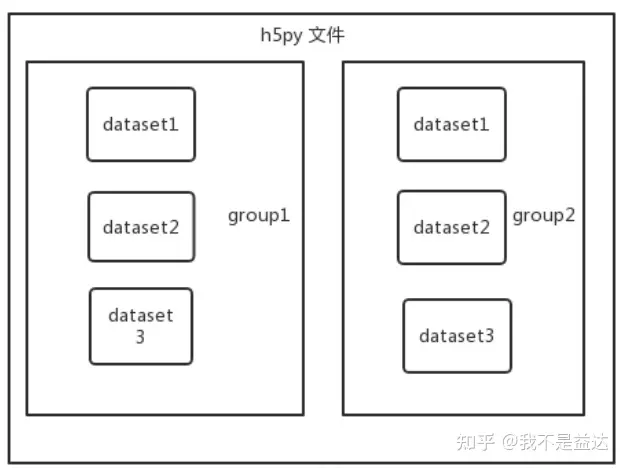!
In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)
   在多线圈MRI中，k空间具有以下形状：（切片数量、线圈数量、高度、宽度）

In [16]:
volume_kspace = hf['kspace'][()]
print('Kspace shape:',volume_kspace.shape)
out = hf['reconstruction_rss'][()]
print('reconstruction rss shape:',out.shape)

Kspace shape: (18, 4, 256, 256)
reconstruction rss shape: (18, 256, 256)


In [17]:
slice_kspace = volume_kspace[8] # 选择 '2022061003_FLAIR01.h5'中第8个切片

In [18]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):  # i从0开始枚举，这里最好命名为coils_num
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

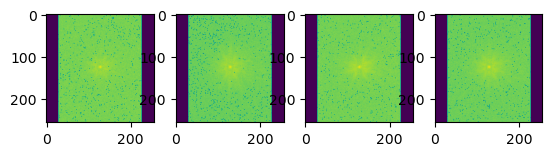

In [19]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 1, 2, 3])  # 展示4个线圈的k空间数据

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

fastMRI repo包含一些将k空间转换为图像空间的utlity函数。这些函数适用于PyTorch张量。to_tensor函数可以将Numpy数组转换为PyTorch张量。

k空间的基本概念：https://wenku.baidu.com/view/1a0dfc48c9aedd3383c4bb4cf7ec4afe04a1b1e7.html?fr=aladdin664466&ind=1&_wkts_=1698666177094&bdQuery=k%E7%A9%BA%E9%97%B4&needWelcomeRecommand=1


In [20]:
import fastmri
from fastmri.data import transforms as T

In [21]:
slice_kspace2 = T.to_tensor(slice_kspace)      # 从numpy数组转换为pytorch张量
slice_image = fastmri.ifft2c(slice_kspace2)    # 应用傅立叶逆变换获得复杂图像
slice_image_abs = fastmri.complex_abs(slice_image)   # 计算绝对值以获得真实图像

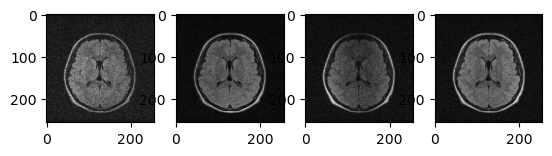

In [22]:
show_coils(slice_image_abs, [0, 1, 2, 3], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

正如我们所看到的，多线圈MRI扫描中的每个线圈都聚焦在图像的不同区域。可以使用统计平方模型（RSS）变换将这些线圈组合成完整图像。

In [23]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

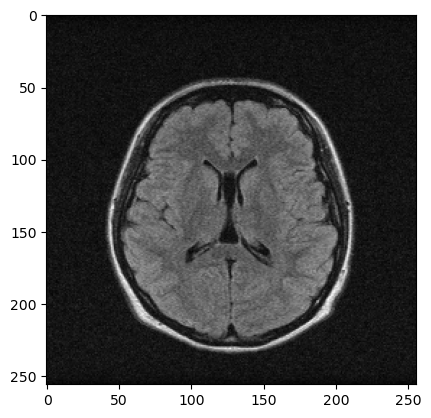

In [24]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.
到目前为止，我们一直在研究完全采样的数据。我们可以通过创建掩码并将其应用于k空间来模拟欠采样数据。

In [38]:
from fastmri.data.subsample import EquispacedMaskFractionFunc
mask_func = EquispacedMaskFractionFunc(center_fractions=[0.04], accelerations=[3])  # 创建掩码函数对象 Create the mask function object

In [39]:
masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # 将掩码应用于k空间 Apply the mask to k-space

Let's see what the subsampled image looks like:

让我们看看子采样图像是什么样子的：

In [40]:
sampled_image = fastmri.ifft2c(masked_kspace)           # 应用傅立叶逆变换获得复杂图像 Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)  # 计算绝对值以获得真实图像 Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

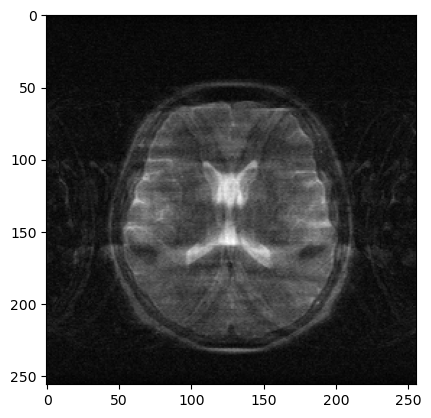

In [41]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')

Let's inspect the header
检查header

In [42]:
header = hf['ismrmrd_header'][()].decode()

In [43]:
print(header)

<ns0:ismrmrdHeader xmlns:ns0="http://www.ismrm.org/ISMRMRD" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.ismrm.org/ISMRMRD ismrmrd.xsd">
   <ns0:studyInformation>
      <ns0:studyUID>2022061003</ns0:studyUID>
      <ns0:studyTime>165418</ns0:studyTime>
   </ns0:studyInformation>
   <ns0:measurementInformation>
      <ns0:measurementID>2022061003_FSE01</ns0:measurementID>
      <ns0:seriesInstanceUID>1.2.156.110001.1.1001.5694.2022061003.20220610.14</ns0:seriesInstanceUID>
      <ns0:patientPosition>HFS</ns0:patientPosition>
      <ns0:protocolName>FSE(Sat) 5mmT--V</ns0:protocolName>
      <ns0:frameOfReferenceUID>1.2.156.110001.1.2022.6.10.17</ns0:frameOfReferenceUID>
   </ns0:measurementInformation>
   <ns0:acquisitionSystemInformation>
      <ns0:systemVendor> XinGaoYi Medical Equipment Co.,Ltd.</ns0:systemVendor>
      <ns0:systemModel>XGY OPER-0.3</ns0:systemModel>
      <ns0:systemFieldStrength_T>0.3</ns0:systemFieldStrength_T>
      <ns0:ac

let's look at how to use the multiple repetitions

MRI术语：重复时间(repetition time，TR) 是指脉冲序列执行所需的时间。在SE序列中TR即指相邻两个90。脉冲中点间的时间间隔；在梯度回波TR是指相邻两个小角度脉冲中点之间的时间间隔；在反转恢复序列和快速反转恢复序列中，TR是指相邻两个180。反转脉冲中点间的时间间隔；在单次激发序列中，只有一个90。脉冲激发，TR等于无穷大。

In [46]:
import xmltodict
header_dict = xmltodict.parse(header)

In [47]:
singlenex_img = out.copy()
multinex_img = out;
# you can find the info of other repetitions directly in the header.
for other_rep in header_dict['ns0:ismrmrdHeader']["ns0:repetitionInformation"]['ns0:repetitionLabel']:
    with h5py.File(os.path.join(data_folder, other_rep['ns0:MeasurementID']+'.h5')) as hf:
        multinex_img += hf['reconstruction_rss'][()]

plt.imshow(np.concatenate((singlenex_img[8], multinex_img[8]/3), axis=1), cmap='gray', vmax=60)
plt.title('single repetition VS multi-repetition averaged')

Note that in the above image, the multi-reptition (NEX) averaged image has higher SNR (theoretically 1.7x) than the single-repetition image

注意，在上述图像中，多报告（NEX）平均图像比单重复图像具有更高的SNR（理论上为1.7x）